# Evaluation of results

In this notebook, the "Evaluation" part of the thesis is analysed.

## Installs

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
!pip install sentence-transformers
!pip install rdflib
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

! pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 85 kB 4.1 MB/s 
     |████████████████████████████████| 5.8 MB 73.7 MB/s 
     |████████████████████████████████| 1.3 MB 59.2 MB/s 
     |████████████████████████████████| 182 kB 60.5 MB/s 
     |████████████████████████████████| 7.6 MB 47.8 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=d20d52dd8613fe9f63942fcdaacaba7dec10eae48e49969201ecdbb1fa36939a
  Stored in directory: /root/.cache/pip/wheels/5e/6f/8c/d88aec621f3f542d26fac0342bef5e693335d125f4e54aeffe
Successfully built sentence-transformers
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 500 kB 13.8 MB/s 
     |████████████████████████████████| 41 kB 571 kB/s 
1.13.0+cu116
     |████████████████████████████████| 9.4 MB 6.5 MB/s 
 

## Imports & Data

In [ ]:
import seaborn as sns

In [ ]:
import torch.nn.functional as F
import os
import torch
import numpy as np
import random


from typing import List, Callable

from torch import Tensor, device
import pandas as pd
import pickle
import torch

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
os.chdir("/content/gdrive/My Drive/1_Studium/2_Master/Master Thesis/2_Projekt/Scratch/all_in/MAGNET")

In [ ]:
import evaluation.interpretation as interpretation_funcs

In [ ]:
PATH = "/content/gdrive/My Drive/1_Studium/2_Master/Master Thesis/2_Projekt/Scratch/all_in/MAGNET/results/trainings/GCN/"

In [ ]:
with open(PATH + "matchesV13_case_a", "rb") as fp:   # Unpickling
    matches_model = pickle.load(fp)

In [ ]:
output = torch.load("/content/gdrive/My Drive/1_Studium/2_Master/Master Thesis/2_Projekt/Scratch/all_in/MAGNET/results/trainings/GCN/macheinfach")

In [ ]:
final_matches = matches_model[998]

In [ ]:
os.chdir("/content/gdrive/My Drive/1_Studium/2_Master/Master Thesis/2_Projekt/Scratch/all_in/data")
use_case = "anatomy"
a_or_b = "case_a"
data = torch.load(use_case +  "/" + a_or_b + ".pt")

In [ ]:
gold_standard = list(map(list, zip(data.left_indices.tolist(), data.right_indices.tolist())))

## Confidence

In [ ]:
# plot function
def plot_conf(data):
    
    plt.figure(figsize=(14, 6), dpi=80)

    ax = sns.lineplot(data=data["Confidence"], palette=['b'])
    ax.set(xlabel='Epochs', ylabel='Similarity / Confidence')
    ax.yaxis.get_label().set_fontsize(20)
    ax.xaxis.get_label().set_fontsize(20)
    ax.tick_params(axis="x", labelsize=15)
    ax.tick_params(axis="y", labelsize=15)
    ax.set(ylim=(0, 1))


    plt.show()


### Change

In [ ]:
res = []
sum = 0
for i in range(0, len(matches_model)):
  sum = 0
  for item in matches_model[i]:
    sum=sum + item[2:][0] 
  try:
    res.append(sum/ len(matches_model[i]))
  except:
    res.append(0)

In [ ]:
conf_res = pd.DataFrame({'Confidence':res})

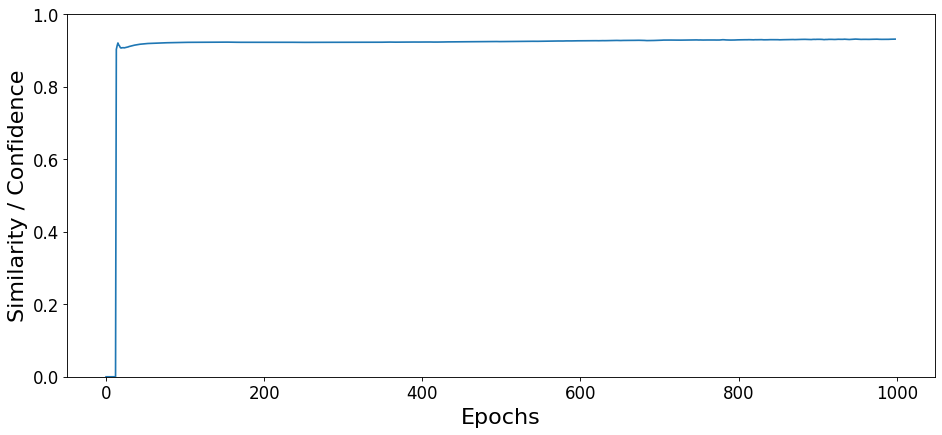

In [ ]:
plot_conf(conf_res)

### True vs False Alignment

In [ ]:
# Plan: 2 listen erstellen, eine nur mit echten matches und eine mit unechten und schauen, ob sich die confidence unterscheidet

In [ ]:
right_matches = [item for item in final_matches if item[0:2] in gold_standard]

In [ ]:
wrong_matches = [item for item in final_matches if item[0:2] not in gold_standard]

In [ ]:
sum = 0 
for item in right_matches:
    sum = sum + item[2:][0] 
print(sum / len(right_matches))

0.9426150064821278


In [ ]:
sum = 0 
for item in wrong_matches:
    sum = sum + item[2:][0] 
print(sum / len(wrong_matches))

0.9134399688605106


In [ ]:
gold_standard_val = list(map(list, zip(data.val_set_left.tolist(), data.val_set_right.tolist())))


In [ ]:
right_matches = [item for item in final_matches if item[0:2] in gold_standard_val]
wrong_matches = [item for item in final_matches if item[0:2] not in gold_standard_val]

In [ ]:
sum = 0 
for item in right_matches:
    sum = sum + item[2:][0] 
print(sum / len(right_matches))

0.923629879951477


In [ ]:
sum = 0 
for item in wrong_matches:
    sum = sum + item[2:][0] 
print(sum / len(wrong_matches))

0.9320724633591013


## Match Level

### Hits@k

In [ ]:
output[1:] = output

In [ ]:
# get the indices

indices = [m[0] for m in matches]

In [ ]:
gold_standard = list(map(list, zip(data.left_indices.tolist(), data.right_indices.tolist())))
gold_standard_val = list(map(list, zip(data.val_set_left.tolist(), data.val_set_right.tolist())))
gold_standard_test = list(map(list, zip(data.test_set_left.tolist(), data.test_set_right.tolist())))

In [ ]:
output_filtered = [output[i] for i in indices]


In [ ]:
# indices are the left graph items!
# now we create the right graph items

In [ ]:
big_gr = []
for m in output_filtered:
  g_r = []
  for d in m:
    g_r.append(d['corpus_id'])
  big_gr.append(g_r)

In [ ]:
smaller_gr = [gr[0:1] for gr in big_gr]


In [ ]:
false_positives = 0
match_count=0
prec = 0
recall = 0

for left, right in zip(indices, smaller_gr):
  if any(left in sublist for sublist in gold_standard):
    for element in right:
      if any(element in sublist for sublist in gold_standard): # Check if we should count this match
        if [left, element] in gold_standard:
          match_count = match_count + 1
        else:
          false_positives = false_positives + 1
print(match_count)
false_negatives = len(gold_standard) - match_count # alle matches, die er nicht gefunden hat

In [ ]:
# hits@10 on complete: 0.8496042216358839
# test: 0.6138613861386139
# val : 0.6447368421052632


# hits @ 3: 
# complete: 0.8100263852242744
# test: 0.5676567656765676
# val: 0.5986842105263158


### Common mix ups

Look Up of partners happen in Postprocessing notebook to avoid code copying.

In [ ]:
from collections import Counter

In [ ]:
matching_partner = [item[1:2][0] for item in final_matches]

In [ ]:
Counter(matching_partner).most_common(1)

[(4079, 5)]

In [ ]:
for key, val in data.res_map_two.items():
  if val in [159, 162, 697, 1158, 2674]:
    print(key)

http://human.owl#NCI_C32969
http://human.owl#genid1420
http://human.owl#genid3387
http://human.owl#genid3730
http://human.owl#genid6269


In [ ]:
[x[0:1][0] for x in final_matches if x[1:2][0]==4079]

[159, 162, 697, 1158, 2674]

## Data

In [ ]:
# Investigation of differences between the graphs

In [ ]:
os.chdir("/content/gdrive/My Drive/1_Studium/2_Master/Master Thesis/2_Projekt/Scratch/all_in/data")
use_case = "anatomy"
a_or_b = "case_a"
anatomy = torch.load(use_case +  "/" + a_or_b + ".pt")

In [ ]:
use_case = "common_kg"
a_or_b = "case_a"
common_kg = torch.load(use_case +  "/" + a_or_b + ".pt")

In [ ]:
use_case = "dbp15k"
dbp15k = torch.load(use_case +  "/" + use_case + ".pt")

In [ ]:
anatomy

In [ ]:
len(anatomy.edge_index_one[0])

5957

In [ ]:
edge_index_two, x_two, edge_attr_emb_two

In [ ]:
len(common_kg.x_one)

8370

In [ ]:
dbp15k

Data(x_one=[19993, 512], edge_index_one=[2, 115722], x_two=[19661, 512], edge_index_two=[2, 105998], train_set_left=[4499], train_set_right=[4499], test_set_left=[10500], test_set_right=[10500])

##### Amount of training data in comparison to the nodes
- anatomy: 1061 / 1516 / L. 3105 / R. 9423
- common_kg: 212 / 304 / L. 8370 / R. 9149
- dbp15k: 10500 / 15000 / L. 15000 / R. 15000



##### Connectivity
- anatomy: L. 5957, R.13196
- common_kg: L. 8726, R. 9172
- dbp15k: l:115722, r. 105998